In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [ ]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embeddings_model = OpenAIEmbeddings(model = "text-embedding-3-large")

#데이터 로딩
vector_store = Chroma(
    collection_name='chroma-req',
    embedding_function=embeddings_model,
    persist_directory='./chroma-req'
)

retriever = vector_store.as_retriever(search_kwargs={'k':2})

In [2]:
from typing_extensions import List, TypedDict
from langchain_core.documents import Document
from langgraph.graph import StateGraph, START, END

class ReqState(TypedDict):
    req_actor: List[str]
    req_names: List[str]
    req_purpose: List[str]
    req_importance: List[str]
    req_level: List[str]
    req_function: List[str]
    req_process: List[str]
    req_screen: List[str]
    req_security: List[str]
    req_perform: List[str]
    req_data: List[str] 

In [3]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model = "gpt-4o")

내가 만들 부분에서는 아래 부분이 이미 채워서 들어온다.
- req_actor
- req_names
- req_purpose
- req_importance
- req_level
- req_funcion
- req_process 

여기서 해야할 것은 아래 것들 중 어떤 것이 추가로 필요한지 확인하고 각각의 tools 를 병행적으로 호출하기
- req_screen
- req_security
- req_perform
- req_data
 
이때 의문인 점, 각각의 tool 이 담긴 노드를 병렬적이면서 분기적으로 호출이 가능한가? -> 일단 가능

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from typing import Literal, List

class Route(BaseModel):
    targets: List[Literal["req_screen", "req_security", "req_perform", "req_data"]] = Field(
        description="The target(s) for the query to answer"
    )

router_system_prompt = """
당신은 랭체인의 route 노드이다. 당신은 요구사항 명과 요구사항 목적, 기능, 프로세스 흐름에 따라 "화면 요구사항", "보안 요구사항", "성능 및 용량 요구사항", "데이터 요구사항" 의 경로를 정해야한다.
당신은 필요한 만큼 복수의 선택 결과를 반환할 수 있다. (예시 ['화면 요구사항', '성능 및 용량 요구사항'])
'화면 요구사항' 는 요구사항을 바탕으로 구체적인 화면 요구사항이 필요할 때 선택해야한다.
'보안 요구사항' 는 요구사항을 바탕으로 구체적인 보안 요구사항이 필요할 때 선택해야한다.
'성능 및 용량 요구사항' 는 요구사항을 바탕으로 구체적인 성능 및 용량 요구사항이 필요할 때 선택해야한다.
'데이터 요구사항' 는 요구사항을 바탕으로 구체적인 데이터, DB 구성 요구사항이 필요할 때 선택해야한다.

요구사항
- 시스템 : {req_actor}
- 요구사항 명 : {req_names}
- 요구사항 목적 : {req_purpose}
- 요구사항 중요도 : {req_importance}
- 요구사항 난이도 : {req_level}
- 기능 요구사항 : {req_function}
- 프로세스 요구사항 : {req_process}
- 기획서 context : {proposal_context}
"""

router_prompt = ChatPromptTemplate.format_prompt(
    router_system_prompt
)

router_llm = ChatOpenAI(model = "gpt-4o")
structed_router_llm = router_llm.with_structured_output(Route) 

def router(state: ReqState) -> List[Literal["화면 요구사항", "보안 요구사항", "성능 및 용량 요구사항", "데이터 요구사항"]]:
    """
    사용자의 질문을 기반으로 필요한 복수의 경로를 결정합니다.
    
    Args:
        state (ReqState): 다양한 요구사항 정보를 담은 현재 state
        
    Returns:
        List[Literal["화면 요구사항", "보안 요구사항", "성능 및 용량 요구사항", "데이터 요구사항"]]: 
        질문을 처리하기 위한 적절한 경로를 나타내는 문자열(들)을 반환한다.      
    """
    req_actor = state["req_actor"]
    req_names = state['req_names']
    req_purpose = state["req_purpose"]
    req_importance = state["req_importance"]
    req_level = state["req_level"]
    req_function = state['req_function']
    req_process = state['req_process']

    proposal_context = retriever.invoke(req_names)
    
    router_chain = router_prompt | structed_router_llm
    
    route = router_chain.invoke({
        "req_actor": req_actor,
        "req_names": req_names,
        "req_purpose": req_purpose,
        "req_importance": req_importance,
        "req_level": req_level,
        "req_function": req_function,
        "req_process": req_process,
        "proposal_context" : proposal_context
    })
    
    print(f"라우터 결과 : {route.targets}")
    return {"req_targets" : route.targets}

In [ ]:
from langchain.tools import DuckDuckGoSearchRun
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool

search_tool = DuckDuckGoSearchRun()
tools = [search_tool]
tool_node = ToolNode(tools)

In [ ]:
# class DetailRequirements(BaseModel):
#     req_screen: str = Field(description="화면 요구사항에 대한 모든 정보")
#     req_security: str = Field(description="보안 요구사항에 대한 모든 정보")
#     req_perform: str = Field(description="성능 및 용량 요구사항에 대한 모든 정보")
#     req_data: str = Field(description="데이터 및 DB 요구사항에 대한 모든 정보")

In [9]:
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate

class DetailRequirements(BaseModel):
    req_screen: str = Field(description="화면 요구사항에 대한 모든 정보")
    req_security: str = Field(description="보안 요구사항에 대한 모든 정보")
    req_perform: str = Field(description="성능 및 용량 요구사항에 대한 모든 정보")
    req_data: str = Field(description="데이터 및 DB 요구사항에 대한 모든 정보")

nonfuntional_req_prompt = """
당신은 전문적인 프로젝트 설계자입니다. 다음 요구사항을 바탕으로 아래 세부 요구사항을 작성해야합니다.
1. 화면 요구사항, 2. 보안 요구사항, 3. 성능 및 용량 요구사항, 4. 데이터 및 DB 요구사항
4가지 세부 요구사항 중 필요한 부분만 요구사항을 작성할 수 있고, 구체적인 요구사항이 필요하지 않다면, ' ' 공백문자로 반환할 수 있습니다.
당신은 실제 현업에서 활용 되는 방식으로 요구사항을 정리해야하며, 요구사항은 정리되어있고, 순서가 있고, 같은 요구사항 안에서 일관적이어야 합니다.

요구사항
- 요구사항 명 : {req_names}
- 요구사항 목적 : {req_purpose}
- 기능 요구사항 : {req_function}
- 프로세스 요구사항 : {req_process}
- 기획서 context : {proposal_context}
"""

generate_prompt = ChatPromptTemplate.from_template(
    nonfuntional_req_prompt
)

structed_generate_llm = llm.with_structured_output(DetailRequirements)
# structed_generate_llm_with_tool = structed_generate_llm.bind_tools(tools)

def generate_nonfunctional_req(state: ReqState) -> ReqState:
    """
    요구사항 기초 정보를 기반으로 세부 요구사항을 만듭니다.
    
    Args:
        state (ReqState): 기능 요구사항 정보를 담은 현재 state
        
    Returns:
        state (ReqState) : 세부 요구사항 정보를 추가한 state   
    """

    screens = []
    securitys = []
    performs = []
    datas = []

    generate_chain = generate_prompt | structed_generate_llm

    req_names_list = state['req_names']
    req_purpose_list = state['req_purpose']
    req_function_list = state['req_function']
    req_process_list = state['req_process']

    for names, purpose, function, process in zip(
        req_names_list, 
        req_purpose_list, 
        req_function_list, 
        req_process_list
    ):
        # retriever를 각 req_name에 맞게 호출합니다.
        proposal_context = retriever.invoke(names)

        # 현재 묶인 하나의 요구사항 세트를 invoke에 전달합니다.
        details = generate_chain.invoke({
            "req_names": names,
            "req_purpose": purpose,
            "req_function": function,
            "req_process": process,
            "proposal_context": proposal_context
        })
        
        screens.append(details.req_screen)
        securitys.append(details.req_security)
        performs.append(details.req_perform)
        datas.append(details.req_data)

    return {"req_screen" : screens, "req_security" : securitys, "req_perform" : performs, "req_data" : datas}
    

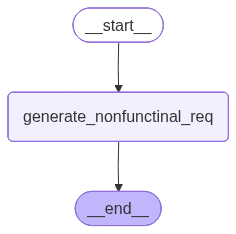

In [10]:
builder = StateGraph(ReqState)

builder.add_node("generate_nonfunctinal_req", generate_nonfunctional_req)

builder.add_edge(START, "generate_nonfunctinal_req")
builder.add_edge("generate_nonfunctinal_req", END)

sj_graph = builder.compile()

sj_graph